In [165]:
from sbdataextraction import sbdataextraction as sbd
from statsbomb_event_parsing import plot_event

import time 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms.traversal.depth_first_search import dfs_edges
from networkx.algorithms.dag import dag_longest_path

In [2]:
season_11_21 = sbd.fetch_matches_for_season(11, 21)


Fetching matches for season_id 21 of competition_id 11...
[==================================] 100%

In [58]:
event_df = season_11_21[69239].get_events_for_game()
for game_id, game in season_11_21.items():
    if game_id == 69239:
        continue
    event_df = event_df.append(game.get_events_for_game())

In [4]:
events_graph = nx.Graph()
events_graph.add_nodes_from(events_df.index)

for index, row in events_df.iterrows():
    if row["related events"] is not None:
        events_graph.add_edges_from([(index, x) for x in row["related events"] if x in events_df.index])

In [5]:
events_graph

In [6]:
def largest_distance(my_graph):
    """
    Function which takes a graph and returns a tuple containing:
    1. the maximum degree of separation between any two vertices
    2. a set of all pairs of vertices whose separation is maximum
    
    Arguments:
    ----------
    my_graph (nx.Graph object) 
        - graph for which we want to find the pairs of nodes which have the highest degree of separation
    
    Returns:
    --------
    (tuple) 
        - maximum degree of separation, set of pairs of vertices whose separation is maximum
    """
    assert str(type(my_graph)) == "<class 'networkx.classes.graph.Graph'>"
    
    #keep track of highest degree of separation
    largest_nodes_set = set()
    largest_distance = 0

    for node, dict_of_distances in nx.shortest_path_length(my_graph):
        
        #keep track of highest degree of separation for current node
        max_node_distance = 0
        furthest_nodes_from_node = set()
        
        #check degree of separation with other nodes, form new set if greater than current max degree of separation
        for other_node, distance in dict_of_distances.items():
            
            if distance > max_node_distance:
                max_node_distance = distance
                new_pair = tuple(sorted((node, other_node)))
                furthest_nodes_from_node = {new_pair}
            
            #add pair of notes to set if equal to current max degree
            elif distance == max_node_distance and distance:
                new_pair = tuple(sorted((node, other_node)))
                furthest_nodes_from_node.add(new_pair)
        
        #check if max degree of seperation for this node is greater than overall max degree of separation
        #form new set if greater than current max degree of separation
        if max_node_distance > largest_distance:
            largest_distance = max_node_distance
            largest_nodes_set = furthest_nodes_from_node
        #add pairs of nodes to set if equal to current max degree of separation
        elif max_node_distance == largest_distance:
            largest_nodes_set = largest_nodes_set | furthest_nodes_from_node

    return largest_distance, largest_nodes_set

def get_sequences(event_graph):
    """
    
    """
    sequences = []
    for connected_comp in list(nx.connected_components(events_graph)):
        graph = events_graph.subgraph(connected_comp)
        nodes = largest_distance(graph)
        if nodes[0] != 0:
            path = nx.shortest_path(graph,
                                    source=list(nodes[1])[0][0], 
                                    target=list(nodes[1])[0][1])

            sequences.append(path)
    
    return sequences

In [24]:
all_sequences = get_sequences(events_graph)
all_sequences[5]

['63b97473-e197-47f5-bed4-674de6dff74d',
 '86b28536-d1c4-4186-aa6b-dd4374d55808']

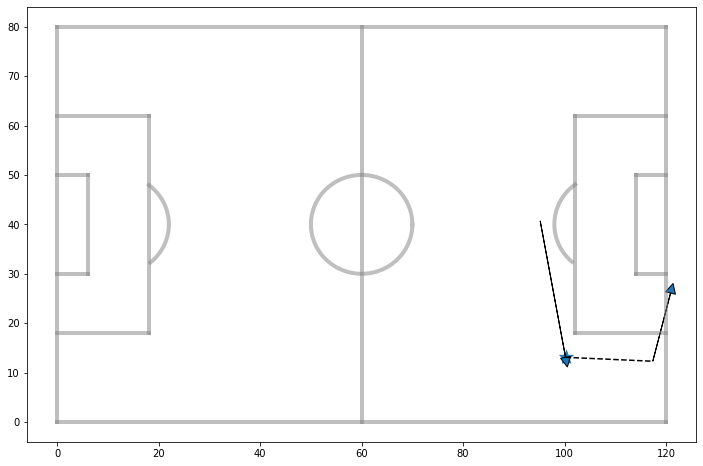

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(120/10, 80/10))
sbd.draw_pitch(axis=ax, rotate=True)
for sequence in all_sequences[4:5]:
    for event in sequence:
        plot_event(events_df=events_df, eventid=event, axis=ax)

## 3. Pass clustering

In [179]:
import math
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [93]:
pass_df = event_df[event_df["event name"] == "pass"].iloc[:, 5:9]
x1 = pass_df["x start location"]
x2 = pass_df["x end location"]
y1 = pass_df["y start location"]
y2 = pass_df["y end location"]
pass_df["length"] = np.sqrt((x2-x1)**2 + (y2-y1)**2)
pass_df["angle"] = list(map(lambda x, y: math.atan2(x, y), x2-x1, y2-y1))
pass_df

,x start location,y start location,x end location,y end location,length,angle
event id,,,,,,
8a7a2c38-f0fe-4707-ba9c-4f7c85bd9247,61.0,41.0,62.1,40.1,1.421267,2.256526
a5625b97-1c9d-4262-9179-0ac2ba69867f,62.8,46.1,69.9,68.0,23.022163,0.313509
af327f67-0dd3-4464-a505-e0c7bde4d29d,71.6,75.1,92.5,79.9,21.444113,1.345046
09e078a9-cfa2-4a03-8d4d-a33529d95819,105.5,80.0,80.2,69.4,27.430822,-1.967550
5b7a45a1-3cc3-4cf1-ad60-69bef51ec545,76.5,60.2,54.0,40.9,29.643549,-2.279788
...,...,...,...,...,...,...
6a0f145b-d417-484c-ae38-37054e4703ef,62.9,76.2,80.8,65.5,20.854256,2.109571
9075d00f-ad29-4dad-b010-1a9c12742a1a,80.8,65.5,115.2,47.9,38.640911,2.043703
83b1e530-2286-492c-971d-3759c6ec85d5,9.4,48.9,80.0,57.5,71.121867,1.449580


In [161]:
cols = ["x start location", "y start location", "length", "angle"]
ss = StandardScaler()
pass_df_trans = ss.fit_transform(pass_df[cols])
pass_df_trans

array([[ 0.07680454,  0.02384468, -1.37677736,  1.00425552],
       [ 0.14629899,  0.24426414,  0.1189719 , -0.08715424],
       [ 0.48604963,  1.49762972,  0.00970019,  0.49226927],
       ...,
       [-1.91536967,  0.36527875,  3.44962522,  0.55098718],
       [-0.56408871, -0.70656492,  3.20465302,  0.38913384],
       [-1.74549435, -0.61580396,  5.41195851,  0.45406308]])

In [206]:
n_cluster = 50
kmeans = KMeans(n_clusters=n_cluster, n_init=100)
kmeans.fit_predict(pass_df_trans)

array([37, 17, 11, ..., 22, 26, 22], dtype=int32)

In [207]:
pass_df_temp = pass_df.copy()
pass_df_temp["cluster"] = kmeans.labels_

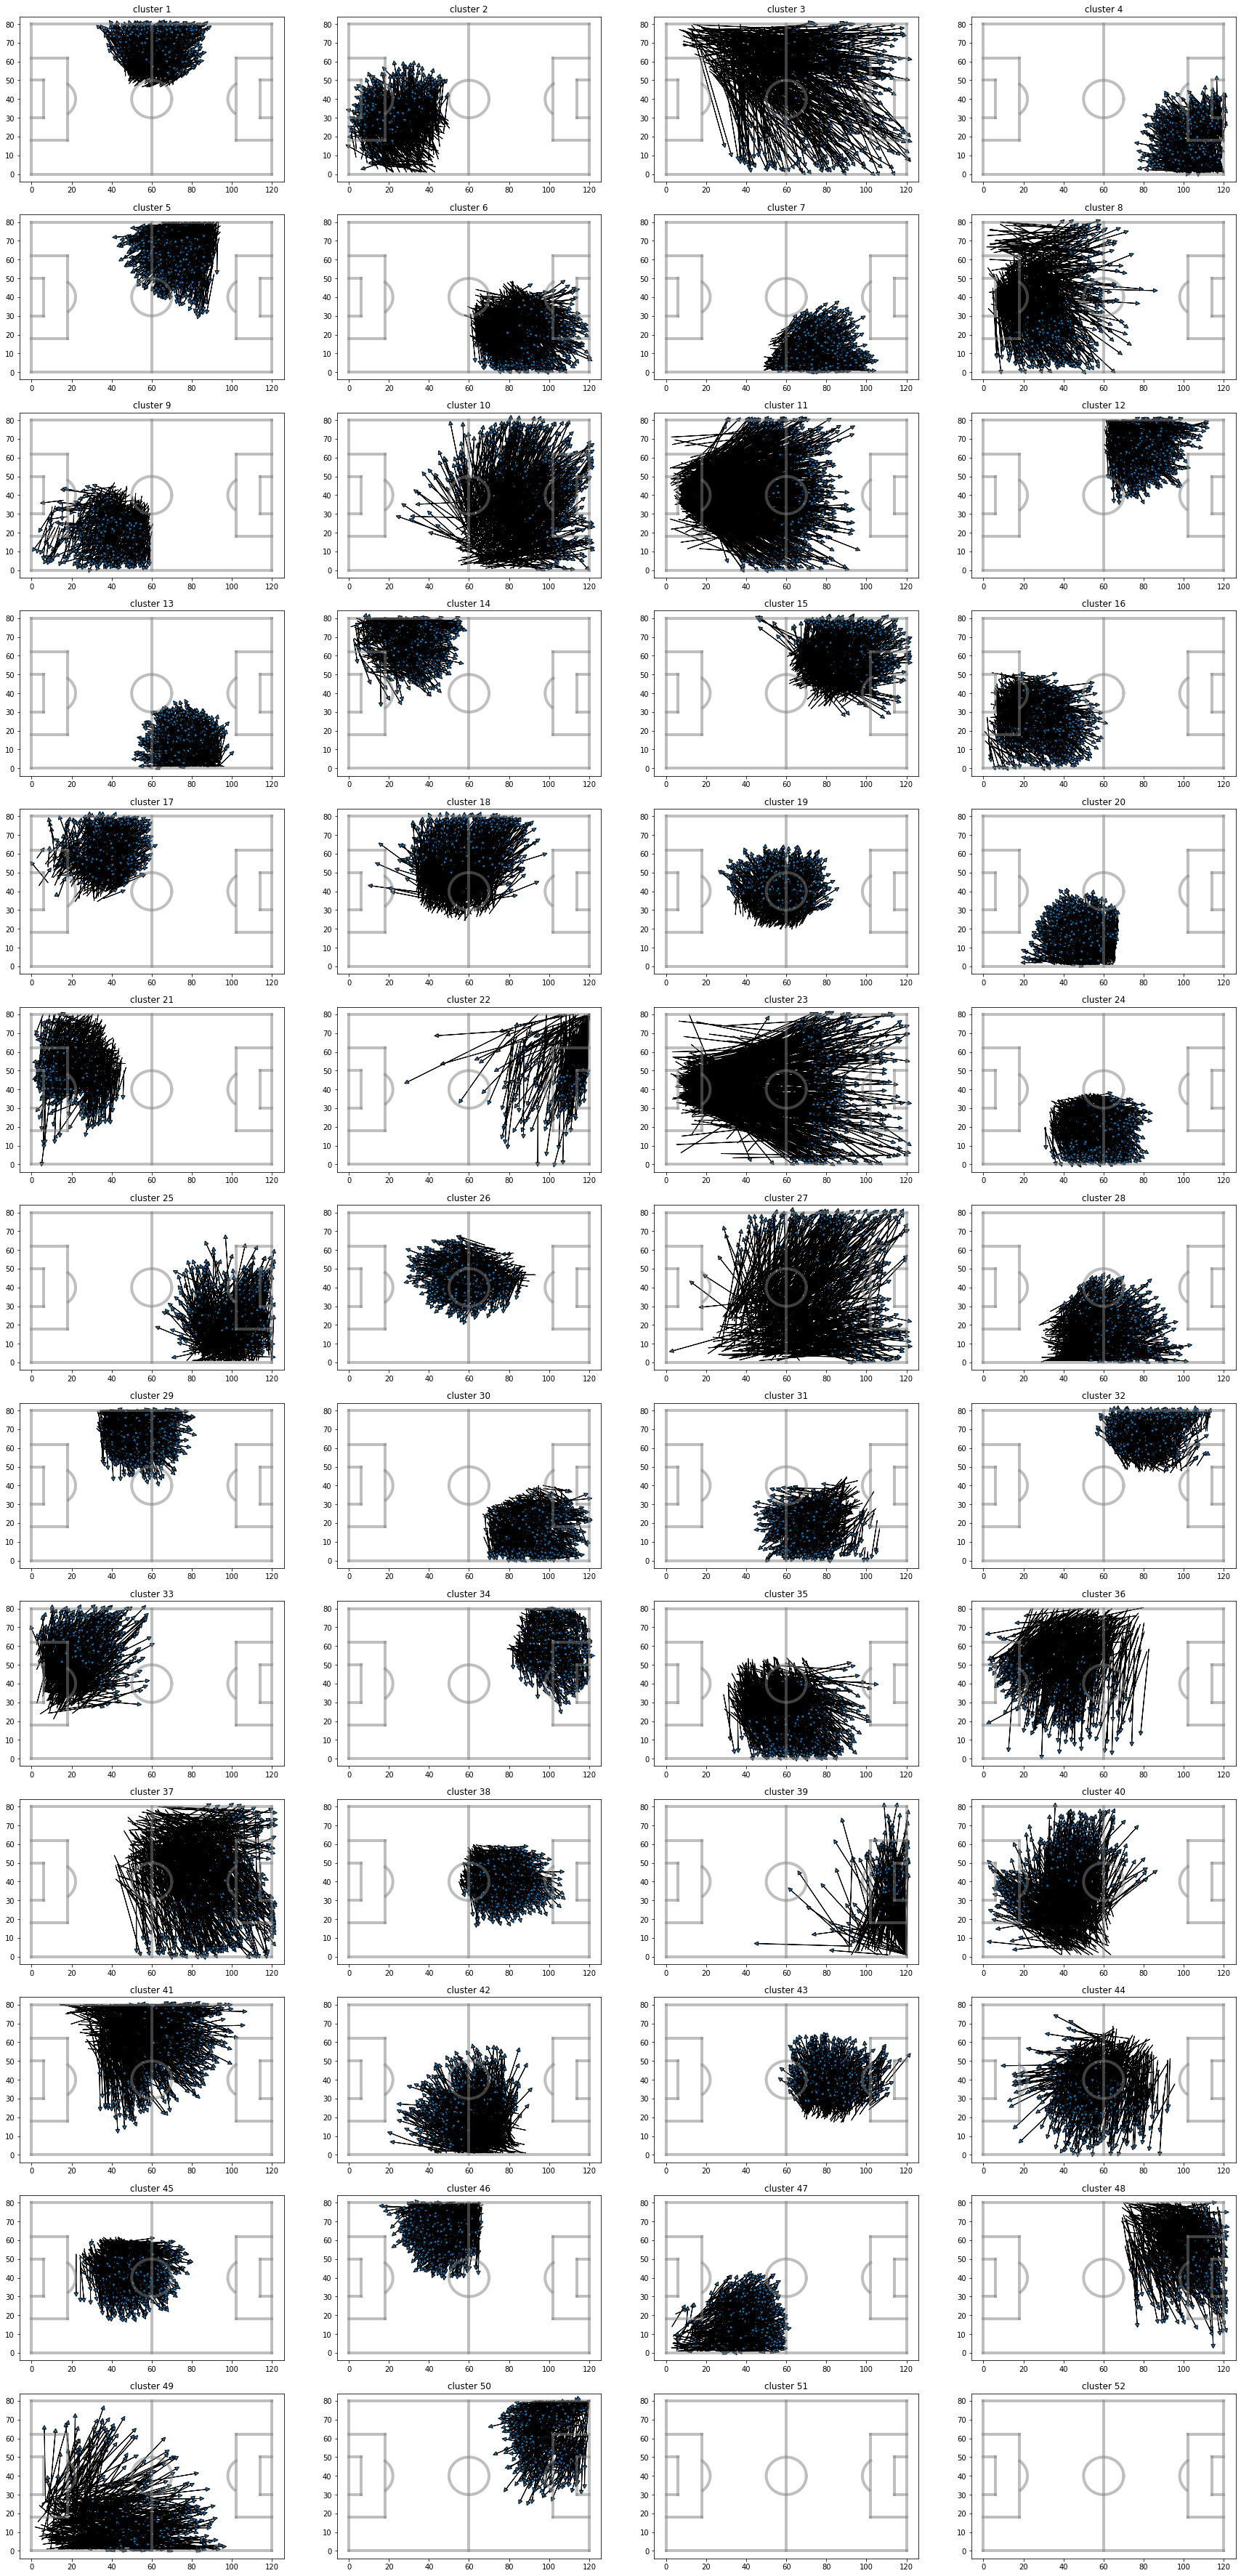

In [208]:
axis_cols = 4
axis_rows = int(np.ceil(n_cluster / axis_cols))
fig, axs = plt.subplots(axis_rows, axis_cols, figsize=(30, 0.66*(30/axis_cols)*axis_rows))
ax = axs.reshape(-1)
for i, axi in enumerate(ax):
    sbd.draw_pitch(axis=axi, rotate=True)
    axi.set_title(f"cluster {i+1}", size=12)
for pass_id, pass_ in pass_df_temp.iterrows():
    axis_num = int(pass_df_temp.loc[pass_id]["cluster"])
    plot_event(event_df, pass_id, axis=ax[axis_num])